In [17]:
import torch
import torch.nn as nn

# Set random seed:
torch.manual_seed(2023)

import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
example_generator = QRSU.get_predefined_generator(difficulty_level=QRSU.DifficultyLevel.EASY, batch_size=32)

In [11]:
example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [12]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## Defining the RNN Model: 

In [13]:
# Creating a simple RNN with PyTorch:


class SimpleRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h = self.rnn_cell(x)[0]
        x = self.linear(h)
        
        return x


In [23]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()
    
# Test loop:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

set_default()

In [24]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

[Epoch 1/10] loss: 1.3737, acc: 25.71% - test_loss: 1.3787, test_acc: 26.71%
[Epoch 2/10] loss: 1.3928, acc: 23.69% - test_loss: 1.3836, test_acc: 25.30%
[Epoch 3/10] loss: 1.3734, acc: 27.32% - test_loss: 1.3846, test_acc: 29.03%
[Epoch 4/10] loss: 1.3340, acc: 31.05% - test_loss: 1.3468, test_acc: 39.11%
[Epoch 5/10] loss: 1.2466, acc: 34.27% - test_loss: 1.2716, test_acc: 33.27%
[Epoch 6/10] loss: 1.2399, acc: 32.56% - test_loss: 1.1646, test_acc: 30.44%
[Epoch 7/10] loss: 1.1668, acc: 34.07% - test_loss: 1.2015, test_acc: 46.77%
[Epoch 8/10] loss: 1.1390, acc: 48.49% - test_loss: 1.2099, test_acc: 50.10%
[Epoch 9/10] loss: 1.1940, acc: 50.10% - test_loss: 1.0882, test_acc: 55.85%
[Epoch 10/10] loss: 1.1170, acc: 54.74% - test_loss: 1.0424, test_acc: 57.16%


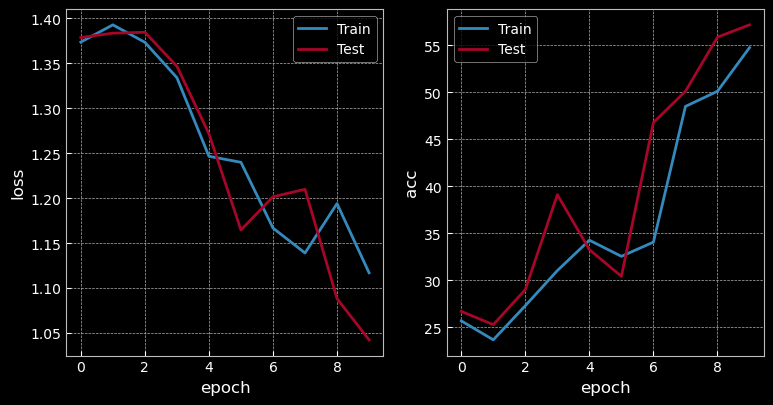

In [25]:
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)